# *import*

In [1]:
# from collections import OrderedDict
from typing import List, Tuple, Callable
import matplotlib.pyplot as plt
from datasets.utils.logging import enable_progress_bar
enable_progress_bar()
import time
import threading
import random
import os
import torch


import flwr
from flwr.client import Client, ClientApp
from flwr.common import ndarrays_to_parameters, Context, Metrics
from flwr.server import ServerApp, ServerConfig, ServerAppComponents

from flwr.simulation import run_simulation

from utils.model_CNN import Net
from utils.model_CNN import SVHNNet
from utils.model_CNN import ConvNet
from utils.train_test import test
from utils.loaddata import get_cached_datasets
from utils.others import get_parameters, set_parameters, evaluate_and_plot_confusion_matrix, weighted_average


from utils.history import history
from utils.client import FlowerClient
from utils.clientmanger import DynamicClientManager
from utils.HRFA_strategy import HRFA
from utils.other_strategy import AdaFedAdamStrategy, MyFedAvg
from utils.dynamic_controll import background_online_offline_simulator


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
# disable_progress_bar()

Training on cuda
Flower 1.17.0 / PyTorch 2.5.1+cu124


# **Load Data**

In [2]:
NUM_CLIENTS = 10
NUM_ROUNDS = 20
NUM_EPOCHS = 5
ATTACK_TYPE = "UPA"
DFL = False
STRATEGY = "HRFA"  # 可選 "FedAvg", "AdaFedAdam", "HRFA"

DATASET = "mnist" #"mnist", "cifar10", "svhn", "fashion_mnist"

# 攻擊者模式設定
ATTACK_MODE = "progressive"  # "fixed": 固定攻擊者數量, "progressive": 攻擊者漸漸變多
ATTACK_INCREASE_ROUNDS = NUM_ROUNDS*0.9  # 僅在 progressive 模式下使用：在前多少輪中逐漸增加攻擊者

#dynamic experiment
if DATASET == "cifar10":
    FRACTION = 0.6
    Q = 0.7
    ATTACK_NUMS = NUM_CLIENTS*0.28
    # ATTACK_NUMS = 0
    Net = ConvNet
elif DATASET == "fashion_mnist":
    FRACTION = 0.5
    Q = 0.8
    ATTACK_NUMS = NUM_CLIENTS*0.28
    # ATTACK_NUMS = 0
    Net = ConvNet
#static experiment
elif DATASET == "mnist":
    FRACTION = 1.0
    Q = 0.0
    # ATTACK_NUMS = (NUM_CLIENTS//2)-1
    ATTACK_NUMS = 2
    Net = Net
else :
    FRACTION = 1.0
    Q = 0.9
    ATTACK_NUMS = (NUM_CLIENTS//2)-1
    # ATTACK_NUMS = 0
    Net = SVHNNet


In [3]:
# trainloader, _, _ = get_cached_datasets(partition_id=0, dataset_name=DATASET, num_partitions=NUM_CLIENTS, q=Q)
# batch = next(iter(trainloader))
# images, labels = batch["img"], batch["label"]

# # Reshape and convert images to a NumPy array
# # matplotlib requires images with the shape (height, width, 3)
# images = images.permute(0, 2, 3, 1).numpy()

# # Denormalize
# images = images / 2 + 0.5

# # Create a figure and a grid of subplots
# fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# # Loop over the images and plot them
# for i, ax in enumerate(axs.flat):
#     ax.imshow(images[i])
#     ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    
#     ax.axis("off")

# # Show the plot
# fig.tight_layout()
# plt.show()

In [4]:
current_server_round = 0
new_round_event = threading.Event()

def get_current_round() -> int:
    return current_server_round

# **Client**

In [5]:
def client_fn(context: Context) -> Client:
    # Load model
    net = Net().to(DEVICE, memory_format=torch.channels_last)
    
	# Read the node_config to fetch data partition associated to this node
    partition_id = str(context.node_config["partition-id"])  # 強制轉換為字串
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = get_cached_datasets(partition_id, dataset_name=DATASET, num_partitions=NUM_CLIENTS, q=Q)

    if int(partition_id) < ATTACK_NUMS:
        return FlowerClient(partition_id, net, trainloader, valloader, ATTACK_TYPE, ATTACK_NUMS, ATTACK_MODE, ATTACK_INCREASE_ROUNDS).to_client()
    else:
        return FlowerClient(partition_id, net, trainloader, valloader).to_client()

# Create the ClientApp
client = ClientApp(client_fn=client_fn)

# **Server**

### setting

In [6]:
def server_evaluate(server_round, parameters, config):
    global current_server_round
    # 更新全域變數，讓背景執行緒知道目前是第幾個 round
    current_server_round = server_round
    """Evaluate the global model after each round (不再畫 confusion matrix)."""
    start_time = time.time()  # 記錄開始時間
    net = Net().to(DEVICE)
    set_parameters(net, parameters)

    # 加載測試集
    _, _, testloader = get_cached_datasets(0, dataset_name=DATASET, num_partitions=NUM_CLIENTS, q=Q)

    # 測試
    loss, accuracy = test(net, testloader)
    
    end_time = time.time()  # 記錄結束時間
    round_time = end_time - start_time  # 計算 round 時間
    
    history.add_loss_centralized(server_round, loss)
    history.add_metrics_centralized(server_round, {"accuracy": accuracy})

    # 只記錄最終模型，不畫 confusion matrix
    if server_round == NUM_ROUNDS:  # 最後一輪才返回模型
        evaluate_and_plot_confusion_matrix(net, testloader, DEVICE)
        return loss, {"accuracy": accuracy}
    new_round_event.set()
    return loss, {"accuracy": accuracy}


In [7]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        # "local_epochs": 1 if server_round < 2 else NUM_EPOCHS,
        "local_epochs": NUM_EPOCHS,
        "train_mode": "lookahead", #no use
    }
    return config

In [8]:
params = get_parameters(Net())
param_count = sum(p.numel() for p in Net().parameters() if p.requires_grad)
print(f"Trainable Parameters: {param_count:,d}")

if STRATEGY == "AdaFedAdam":
    print("Using AdaFedAdam strategy")
    strategy = AdaFedAdamStrategy(
        fraction_fit=FRACTION,
        fraction_evaluate=FRACTION,
        
        min_fit_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_evaluate_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_available_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數

        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=server_evaluate,
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=fit_config,
        net=Net().to(DEVICE),
    )
elif STRATEGY == "FedAvg":
    print("Using FedAvg strategy")
    strategy = MyFedAvg(
        fraction_fit=FRACTION,
        fraction_evaluate=FRACTION,
        
        min_fit_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_evaluate_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數
        min_available_clients=int(NUM_CLIENTS * FRACTION),  # 確保是整數

        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=server_evaluate,
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=fit_config,
    )
else:
    print("Using HRFA strategy")
    strategy = HRFA(
        fraction_fit=FRACTION,  # Sample 100% of available clients for training
        fraction_evaluate=FRACTION,  # Sample 50% of available clients for evaluation
        
        min_fit_clients=2,  # Never sample less than 10 clients for training
        min_evaluate_clients=2,  # Never sample less than 5 clients for evaluation
        min_available_clients=2,  # Wait until all 10 clients are available
        
        initial_parameters=ndarrays_to_parameters(params),  # Pass initial model parameters
        evaluate_fn=server_evaluate,  # 設定 evaluate_fn
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
        on_fit_config_fn=fit_config,  # Pass the fit_config function
        on_evaluate_config_fn=fit_config,
        net=Net().to(DEVICE),
        # testloader = testloader,
    )


Trainable Parameters: 620,810
Using HRFA strategy


### Define Server

In [9]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour."""
    global testloader

    # 設定 ServerConfig，如同你的程式碼
    config = ServerConfig(num_rounds=NUM_ROUNDS)

    # 建立動態管理器
    client_manager = DynamicClientManager()
        
    # 建立並啟動背景執行緒，模擬客戶端動態上/下線
    simulator_thread = threading.Thread(
        target=background_online_offline_simulator,
        args=(client_manager, get_current_round, new_round_event, 0.5, 0.5, DFL),  # interval=30秒, toggle_rate=0.3
        daemon=True  # 設 daemon=True 可以在主程式結束時自動退出
    )
    simulator_thread.start()

    return ServerAppComponents(
        strategy=strategy,
        config=config,
        client_manager=client_manager,
    )


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# *Run simulation*

### Run setting

In [10]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 2 , 
                                           "num_gpus": 0.2 #if (NUM_CLIENTS*FRACTION)>40 else 2/(NUM_CLIENTS*FRACTION)
                                          }}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


[Status] Client 15430430574231216122 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 11177849367905847038 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 2023568308974207363 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 1056972857021028774 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 3603964646809219944 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 3648053208569040682 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 8266104034452673036 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 11450537306252375246 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 15949475656074788240 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 9250987649260019284 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Fri Jul 18 14:07:21 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0
[Fri Jul 18 14:07:21 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0


INFO :      initial parameters (loss, other metrics): 0.03618208923339844, {'accuracy': 0.1053}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0
(ClientAppActor pid=3015625) [Fri Jul 18 14:07:54 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0
(ClientAppActor pid=3015625) [Fri Jul 18 14:07:54 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0


INFO :      aggregate_fit: received 10 results and 0 failures


[Fri Jul 18 14:08:29 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.9
[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'11450537306252375246': np.float64(0.9578110993350301), '2023568308974207363': np.float64(0.9297513522449683), '3648053208569040682': 1.0, '15430430574231216122': 0.0, '15949475656074788240': np.float64(0.3555427295884497), '1056972857021028774': np.float64(0.36756110519157636), '11177849367905847038': np.float64(0.9100060317986622), '9250987649260019284': np.float64(0.3271758957362613), '3603964646809219944': np.float64(0.2863831119814198), '8266104034452673036': np.float64(0.22273176718627138)}
[INFO] shapley_values: {'11450537306252375246': np.float64(0.9578110993350301), '2023568308974207363': np.float64(0.9297513522449683), '3648053208569040682': 1.0, '15430430574231216122': 0.0, '15949475656074788240': np.float64(0.3555427295884497), '10569728570

INFO :      fit progress: (1, 0.02440763818025589, {'accuracy': 0.4559}, 225.16504365298897)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'11450537306252375246': np.float64(0.3529062691206349), '1056972857021028774': np.float64(0.21224622564779366), '3603964646809219944': np.float64(0.24191485879289193), '2023568308974207363': np.float64(0.45057886144966947), '11177849367905847038': 1.0, '9250987649260019284': np.float64(0.7001693159466826), '15949475656074788240': np.float64(0.19334558911635355), '3648053208569040682': np.float64(0.9203690118805407), '15430430574231216122': 0.0, '8266104034452673036': np.float64(0.26724337178293356)}
[INFO] shapley_values: {'11450537306252375246': np.float64(0.3529062691206349), '1056972857021028774': np.float64(0.21224622564779366), '3603964646809219944': np.float64(0.24191485879289193), '2023568308974207363': np.float64(0.45057886144966947), '11177849367905847038': 1.0, '9250987649260019284': np.float64(0.7001693159466826), '15949475656074788240': np.float64(0.19334558911635355), '364

INFO :      fit progress: (2, 0.061795986437797545, {'accuracy': 0.3604}, 393.638762447983)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '2', '6', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'8266104034452673036': np.float64(0.06969327323036806), '11177849367905847038': np.float64(0.3746336365127491), '11450537306252375246': np.float64(0.11179605657962051), '3648053208569040682': np.float64(0.37575616505041026), '2023568308974207363': np.float64(0.09398600058676819), '3603964646809219944': np.float64(0.2691024548993468), '1056972857021028774': np.float64(0.2412194807967778), '9250987649260019284': np.float64(0.25131457347478897), '15949475656074788240': 1.0, '15430430574231216122': 0.0}
[INFO] shapley_values: {'8266104034452673036': np.float64(0.06969327323036806), '11177849367905847038': np.float64(0.3746336365127491), '11450537306252375246': np.float64(0.11179605657962051), '3648053208569040682': np.float64(0.37575616505041026), '2023568308974207363': np.float64(0.09398600058676819), '3603964646809219944': np.float64(0.2691024548993468), '1056972857021028774': np.float64

INFO :      fit progress: (3, 0.014894693323969841, {'accuracy': 0.7437}, 570.9814117400092)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '2', '6', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'8266104034452673036': np.float64(0.12903302890392213), '11177849367905847038': np.float64(0.5259143547409949), '3648053208569040682': np.float64(0.9292686690473653), '1056972857021028774': np.float64(0.07209882629441225), '3603964646809219944': np.float64(0.10634776653430754), '9250987649260019284': 1.0, '15949475656074788240': np.float64(0.4736454896970589), '11450537306252375246': np.float64(0.3332903397431319), '15430430574231216122': 0.0, '2023568308974207363': np.float64(0.2747518699644431)}
[INFO] shapley_values: {'8266104034452673036': np.float64(0.12903302890392213), '11177849367905847038': np.float64(0.5259143547409949), '3648053208569040682': np.float64(0.9292686690473653), '1056972857021028774': np.float64(0.07209882629441225), '3603964646809219944': np.float64(0.10634776653430754), '9250987649260019284': 1.0, '15949475656074788240': np.float64(0.4736454896970589), '1145053

INFO :      fit progress: (4, 0.015774053445458413, {'accuracy': 0.6947}, 745.1358981329831)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'9250987649260019284': np.float64(0.22990460249096883), '15430430574231216122': 0.0, '8266104034452673036': np.float64(0.48104470040986863), '1056972857021028774': np.float64(0.08041664582889302), '15949475656074788240': np.float64(0.8513988017480091), '3648053208569040682': np.float64(0.29326357710996337), '11177849367905847038': 1.0, '11450537306252375246': np.float64(0.09031255270660835), '3603964646809219944': np.float64(0.07569762052770654), '2023568308974207363': np.float64(0.09092614612482233)}
[INFO] shapley_values: {'9250987649260019284': np.float64(0.22990460249096883), '15430430574231216122': 0.0, '8266104034452673036': np.float64(0.48104470040986863), '1056972857021028774': np.float64(0.08041664582889302), '15949475656074788240': np.float64(0.8513988017480091), '3648053208569040682': np.float64(0.29326357710996337), '11177849367905847038': 1.0, '11450537306252375246': np.fl

INFO :      fit progress: (5, 0.013734727504849433, {'accuracy': 0.727}, 919.7117117110174)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '2', '6', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'3603964646809219944': np.float64(0.6130677125155333), '11177849367905847038': 1.0, '9250987649260019284': np.float64(0.2088357167670235), '2023568308974207363': np.float64(0.2307798821143986), '3648053208569040682': np.float64(0.10693034254657544), '1056972857021028774': np.float64(0.13488755711446457), '15430430574231216122': 0.0, '11450537306252375246': np.float64(0.050264275269992414), '15949475656074788240': np.float64(0.16647569649948876), '8266104034452673036': np.float64(0.6086225328402375)}
[INFO] shapley_values: {'3603964646809219944': np.float64(0.6130677125155333), '11177849367905847038': 1.0, '9250987649260019284': np.float64(0.2088357167670235), '2023568308974207363': np.float64(0.2307798821143986), '3648053208569040682': np.float64(0.10693034254657544), '1056972857021028774': np.float64(0.13488755711446457), '15430430574231216122': 0.0, '11450537306252375246': np.float64

INFO :      fit progress: (6, 0.009960799026489258, {'accuracy': 0.7879}, 1094.0626977619831)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '2', '6', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'3648053208569040682': np.float64(0.03224852830525215), '9250987649260019284': np.float64(0.05314490963129651), '8266104034452673036': np.float64(0.05899003721656222), '1056972857021028774': np.float64(0.0337785635495522), '3603964646809219944': np.float64(0.2681720364318273), '11450537306252375246': np.float64(0.04665455345795549), '15430430574231216122': 0.0, '11177849367905847038': 1.0, '2023568308974207363': np.float64(0.01657300189922852), '15949475656074788240': np.float64(0.08578101009088199)}
[INFO] shapley_values: {'3648053208569040682': np.float64(0.03224852830525215), '9250987649260019284': np.float64(0.05314490963129651), '8266104034452673036': np.float64(0.05899003721656222), '1056972857021028774': np.float64(0.0337785635495522), '3603964646809219944': np.float64(0.2681720364318273), '11450537306252375246': np.float64(0.04665455345795549), '15430430574231216122': 0.0, '111

INFO :      fit progress: (7, 0.011235635897517204, {'accuracy': 0.7667}, 1272.2413292290294)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '2', '6', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'15949475656074788240': np.float64(0.20096521592360791), '3603964646809219944': np.float64(0.8791928078479158), '9250987649260019284': np.float64(0.9836454857313548), '2023568308974207363': np.float64(0.03356329243302999), '3648053208569040682': 1.0, '15430430574231216122': 0.0, '8266104034452673036': np.float64(0.07062193917470387), '1056972857021028774': np.float64(0.07987660819289036), '11450537306252375246': np.float64(0.06248526692137443), '11177849367905847038': np.float64(0.11888823142065459)}
[INFO] shapley_values: {'15949475656074788240': np.float64(0.20096521592360791), '3603964646809219944': np.float64(0.8791928078479158), '9250987649260019284': np.float64(0.9836454857313548), '2023568308974207363': np.float64(0.03356329243302999), '3648053208569040682': 1.0, '15430430574231216122': 0.0, '8266104034452673036': np.float64(0.07062193917470387), '1056972857021028774': np.float6

INFO :      fit progress: (8, 0.1462973644256592, {'accuracy': 0.1388}, 1446.6180369289941)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'3648053208569040682': np.float64(0.42895756287069503), '1056972857021028774': np.float64(0.1845814836731351), '9250987649260019284': np.float64(0.8802758716354709), '8266104034452673036': np.float64(0.30851350667936095), '15430430574231216122': 0.0, '3603964646809219944': np.float64(0.20078638265236626), '11450537306252375246': np.float64(0.16966581075329001), '11177849367905847038': 1.0, '2023568308974207363': np.float64(0.6703622391866132), '15949475656074788240': np.float64(0.2489772285643057)}
[INFO] shapley_values: {'3648053208569040682': np.float64(0.42895756287069503), '1056972857021028774': np.float64(0.1845814836731351), '9250987649260019284': np.float64(0.8802758716354709), '8266104034452673036': np.float64(0.30851350667936095), '15430430574231216122': 0.0, '3603964646809219944': np.float64(0.20078638265236626), '11450537306252375246': np.float64(0.16966581075329001), '11177

INFO :      fit progress: (9, 0.012706746941804885, {'accuracy': 0.7443}, 1621.1571049729828)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'1056972857021028774': np.float64(0.1395472375094005), '15430430574231216122': 0.0, '3648053208569040682': np.float64(0.15638674280509712), '9250987649260019284': np.float64(0.2354040489200717), '2023568308974207363': np.float64(0.058424418783303574), '3603964646809219944': np.float64(0.07883313168973687), '11177849367905847038': 1.0, '11450537306252375246': np.float64(0.12085937822248825), '8266104034452673036': np.float64(0.12631745941979214), '15949475656074788240': np.float64(0.17458180909951412)}
[INFO] shapley_values: {'1056972857021028774': np.float64(0.1395472375094005), '15430430574231216122': 0.0, '3648053208569040682': np.float64(0.15638674280509712), '9250987649260019284': np.float64(0.2354040489200717), '2023568308974207363': np.float64(0.058424418783303574), '3603964646809219944': np.float64(0.07883313168973687), '11177849367905847038': 1.0, '11450537306252375246': np.flo

INFO :      fit progress: (10, 0.01685780462026596, {'accuracy': 0.6881}, 1794.9655083040125)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '2', '6', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'15430430574231216122': 0.0, '2023568308974207363': np.float64(0.4059651615668265), '3603964646809219944': np.float64(0.24639986739533087), '8266104034452673036': np.float64(0.22602173357031394), '11177849367905847038': 1.0, '9250987649260019284': np.float64(0.2672606252509415), '15949475656074788240': np.float64(0.46325503985395594), '1056972857021028774': np.float64(0.9959549816267784), '3648053208569040682': np.float64(0.39474160149551313), '11450537306252375246': np.float64(0.36161827218361603)}
[INFO] shapley_values: {'15430430574231216122': 0.0, '2023568308974207363': np.float64(0.4059651615668265), '3603964646809219944': np.float64(0.24639986739533087), '8266104034452673036': np.float64(0.22602173357031394), '11177849367905847038': 1.0, '9250987649260019284': np.float64(0.2672606252509415), '15949475656074788240': np.float64(0.46325503985395594), '1056972857021028774': np.float6

INFO :      fit progress: (11, 0.002239112133719027, {'accuracy': 0.9553}, 1975.8534364940133)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '2', '6', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'11177849367905847038': np.float64(0.8777565151594974), '11450537306252375246': np.float64(0.3410446080856443), '3603964646809219944': np.float64(0.022350569136884935), '2023568308974207363': np.float64(0.4420123196226488), '3648053208569040682': np.float64(0.45633333581291696), '1056972857021028774': 1.0, '8266104034452673036': np.float64(0.8182726711420202), '9250987649260019284': np.float64(0.516469222153438), '15949475656074788240': np.float64(0.23300490833603835), '15430430574231216122': 0.0}
[INFO] shapley_values: {'11177849367905847038': np.float64(0.8777565151594974), '11450537306252375246': np.float64(0.3410446080856443), '3603964646809219944': np.float64(0.022350569136884935), '2023568308974207363': np.float64(0.4420123196226488), '3648053208569040682': np.float64(0.45633333581291696), '1056972857021028774': 1.0, '8266104034452673036': np.float64(0.8182726711420202), '9250987

INFO :      fit progress: (12, 0.001112806872650981, {'accuracy': 0.977}, 2151.076999555982)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'1056972857021028774': np.float64(0.9891552642389986), '8266104034452673036': np.float64(0.867430421026243), '11450537306252375246': np.float64(0.20271854759298752), '11177849367905847038': np.float64(0.014074745705369035), '2023568308974207363': np.float64(0.23543948112210442), '9250987649260019284': 1.0, '15949475656074788240': np.float64(0.6790089782732747), '3648053208569040682': np.float64(0.7409530244264252), '3603964646809219944': np.float64(0.011230699308170337), '15430430574231216122': 0.0}
[INFO] shapley_values: {'1056972857021028774': np.float64(0.9891552642389986), '8266104034452673036': np.float64(0.867430421026243), '11450537306252375246': np.float64(0.20271854759298752), '11177849367905847038': np.float64(0.014074745705369035), '2023568308974207363': np.float64(0.23543948112210442), '9250987649260019284': 1.0, '15949475656074788240': np.float64(0.6790089782732747), '3648

INFO :      fit progress: (13, 0.0008470951527357101, {'accuracy': 0.9816}, 2326.59082294401)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '2', '6', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'1056972857021028774': np.float64(0.6379849898831613), '3603964646809219944': np.float64(0.3690058971405409), '2023568308974207363': np.float64(0.43073304171885696), '15949475656074788240': np.float64(0.4832377702867188), '3648053208569040682': 1.0, '11450537306252375246': np.float64(0.19616681292068783), '11177849367905847038': np.float64(0.2499906533167817), '9250987649260019284': np.float64(0.45750759532083124), '8266104034452673036': np.float64(0.6425289291306602), '15430430574231216122': 0.0}
[INFO] shapley_values: {'1056972857021028774': np.float64(0.6379849898831613), '3603964646809219944': np.float64(0.3690058971405409), '2023568308974207363': np.float64(0.43073304171885696), '15949475656074788240': np.float64(0.4832377702867188), '3648053208569040682': 1.0, '11450537306252375246': np.float64(0.19616681292068783), '11177849367905847038': np.float64(0.2499906533167817), '9250987

INFO :      fit progress: (14, 0.0007852447921410203, {'accuracy': 0.9836}, 2501.015654517978)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'1056972857021028774': 1.0, '8266104034452673036': np.float64(0.28822867444747574), '2023568308974207363': np.float64(0.43818084585401773), '11450537306252375246': np.float64(0.24436241040730336), '15430430574231216122': 0.0, '3603964646809219944': np.float64(0.3549271298442869), '11177849367905847038': np.float64(0.6047947270329685), '9250987649260019284': np.float64(0.6292433651406072), '15949475656074788240': np.float64(0.3308931606603546), '3648053208569040682': np.float64(0.740524307043141)}
[INFO] shapley_values: {'1056972857021028774': 1.0, '8266104034452673036': np.float64(0.28822867444747574), '2023568308974207363': np.float64(0.43818084585401773), '11450537306252375246': np.float64(0.24436241040730336), '15430430574231216122': 0.0, '3603964646809219944': np.float64(0.3549271298442869), '11177849367905847038': np.float64(0.6047947270329685), '9250987649260019284': np.float64(0

INFO :      fit progress: (15, 0.000711366157233715, {'accuracy': 0.9848}, 2679.021040793974)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '2', '6', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'3648053208569040682': 1.0, '11450537306252375246': np.float64(0.1998090821883708), '15949475656074788240': np.float64(0.25002567258310665), '11177849367905847038': np.float64(0.4194472184237659), '8266104034452673036': np.float64(0.5214029364412227), '3603964646809219944': np.float64(0.22984613222267303), '9250987649260019284': np.float64(0.46794173570834496), '1056972857021028774': np.float64(0.25476617283144504), '2023568308974207363': np.float64(0.3659275926457961), '15430430574231216122': 0.0}
[INFO] shapley_values: {'3648053208569040682': 1.0, '11450537306252375246': np.float64(0.1998090821883708), '15949475656074788240': np.float64(0.25002567258310665), '11177849367905847038': np.float64(0.4194472184237659), '8266104034452673036': np.float64(0.5214029364412227), '3603964646809219944': np.float64(0.22984613222267303), '9250987649260019284': np.float64(0.46794173570834496), '10569

INFO :      fit progress: (16, 0.0005972686477005482, {'accuracy': 0.9869}, 2853.505611018976)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'15430430574231216122': 0.0, '8266104034452673036': 1.0, '11177849367905847038': np.float64(0.23463417597131278), '1056972857021028774': np.float64(0.3149422665513832), '2023568308974207363': np.float64(0.2865642232183742), '15949475656074788240': np.float64(0.5808903606302322), '9250987649260019284': np.float64(0.9850159122385455), '3648053208569040682': np.float64(0.8695296192549605), '11450537306252375246': np.float64(0.8685072026027965), '3603964646809219944': np.float64(0.9950097060328694)}
[INFO] shapley_values: {'15430430574231216122': 0.0, '8266104034452673036': 1.0, '11177849367905847038': np.float64(0.23463417597131278), '1056972857021028774': np.float64(0.3149422665513832), '2023568308974207363': np.float64(0.2865642232183742), '15949475656074788240': np.float64(0.5808903606302322), '9250987649260019284': np.float64(0.9850159122385455), '3648053208569040682': np.float64(0.86

INFO :      fit progress: (17, 0.0005961714554578066, {'accuracy': 0.9872}, 3028.378874444985)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'1056972857021028774': np.float64(0.2676744289121718), '15430430574231216122': 0.0, '11450537306252375246': 0.0, '3648053208569040682': np.float64(0.8171700256252719), '9250987649260019284': np.float64(0.5662156788165705), '3603964646809219944': np.float64(0.8047959214898068), '15949475656074788240': np.float64(0.5992443174950557), '8266104034452673036': 1.0, '2023568308974207363': np.float64(0.43184490412274734), '11177849367905847038': np.float64(0.32760112534030544)}
[INFO] shapley_values: {'1056972857021028774': np.float64(0.2676744289121718), '15430430574231216122': 0.0, '11450537306252375246': 0.0, '3648053208569040682': np.float64(0.8171700256252719), '9250987649260019284': np.float64(0.5662156788165705), '3603964646809219944': np.float64(0.8047959214898068), '15949475656074788240': np.float64(0.5992443174950557), '8266104034452673036': 1.0, '2023568308974207363': np.float64(0.4

INFO :      fit progress: (18, 0.0005814838603138923, {'accuracy': 0.9875}, 3203.4341932900134)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '2', '6', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'8266104034452673036': np.float64(0.9145340441866809), '9250987649260019284': np.float64(0.4914074937384773), '3603964646809219944': np.float64(0.2797814513044438), '15949475656074788240': np.float64(0.1715310610340023), '11450537306252375246': 0.0, '2023568308974207363': np.float64(0.4644905705884498), '11177849367905847038': np.float64(0.7085226328011756), '15430430574231216122': 0.0, '3648053208569040682': 1.0, '1056972857021028774': np.float64(0.5323789150944191)}
[INFO] shapley_values: {'8266104034452673036': np.float64(0.9145340441866809), '9250987649260019284': np.float64(0.4914074937384773), '3603964646809219944': np.float64(0.2797814513044438), '15949475656074788240': np.float64(0.1715310610340023), '11450537306252375246': 0.0, '2023568308974207363': np.float64(0.4644905705884498), '11177849367905847038': np.float64(0.7085226328011756), '15430430574231216122': 0.0, '3648053208

INFO :      fit progress: (19, 0.0005463992312550544, {'accuracy': 0.9884}, 3382.11913428799)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


user online: 10 offline: 0


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      aggregate_fit: received 10 results and 0 failures


[INFO] trained_partitions: {'9', '7', '5', '6', '2', '8', '3', '1', '0', '4'}
[INFO] shapley_values: {'15949475656074788240': np.float64(0.7282814109133633), '11450537306252375246': 0.0, '3648053208569040682': np.float64(0.7401444684787517), '1056972857021028774': np.float64(0.16965798781321725), '15430430574231216122': 0.0, '9250987649260019284': np.float64(0.7631030897465509), '2023568308974207363': np.float64(0.7862466587917611), '8266104034452673036': 1.0, '3603964646809219944': np.float64(0.32924940553004606), '11177849367905847038': np.float64(0.7110723744067042)}
[INFO] shapley_values: {'15949475656074788240': np.float64(0.7282814109133633), '11450537306252375246': 0.0, '3648053208569040682': np.float64(0.7401444684787517), '1056972857021028774': np.float64(0.16965798781321725), '15430430574231216122': 0.0, '9250987649260019284': np.float64(0.7631030897465509), '2023568308974207363': np.float64(0.7862466587917611), '8266104034452673036': 1.0, '3603964646809219944': np.float64(0.

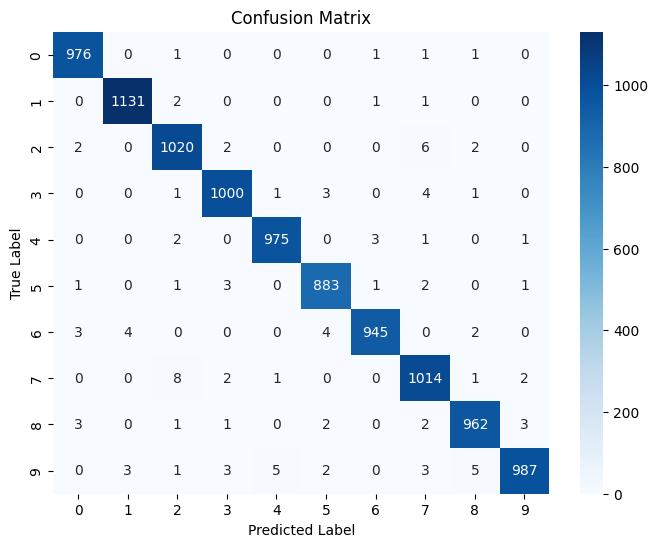

INFO :      fit progress: (20, 0.0004926467500627041, {'accuracy': 0.9906}, 3557.264875848021)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 3558.07s
INFO :      	History (loss, distributed):
INFO :      		round 1: (1.606128446035328, {'accuracy': 0.4410196601132956})
INFO :      		round 2: (3.9861466962470486, {'accuracy': 0.3596301232922359})
INFO :      		round 3: (0.9946263286966913, {'accuracy': 0.7366711096301233})
INFO :      		round 4: (1.0555582495554612, {'accuracy': 0.6780239920026658})
INFO :      		round 5: (0.9183563916425393, {'accuracy': 0.7105131622792402})
INFO :      		round 6: (0.6782347256245116, {'accuracy': 0.7771576141286238})
INFO :      		round 7: (0.7637570255852786, {'accuracy': 0.7625791402865711})
INFO :      		round 8: 

(ClientAppActor pid=3015623) [Fri Jul 18 14:07:54 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
Total Training Time: 3591.39 seconds
Total Training Time: 3591.39 seconds


In [11]:
# 讓 Flower 運行完整的 FL 訓練
start_time = time.time()  # 記錄開始時間

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

end_time = time.time()  # 記錄結束時間
total_time = end_time - start_time  # 計算總時間

print(f"Total Training Time: {total_time:.2f} seconds")  # 顯示總時間

### Loss 和 Accuracy 折線圖

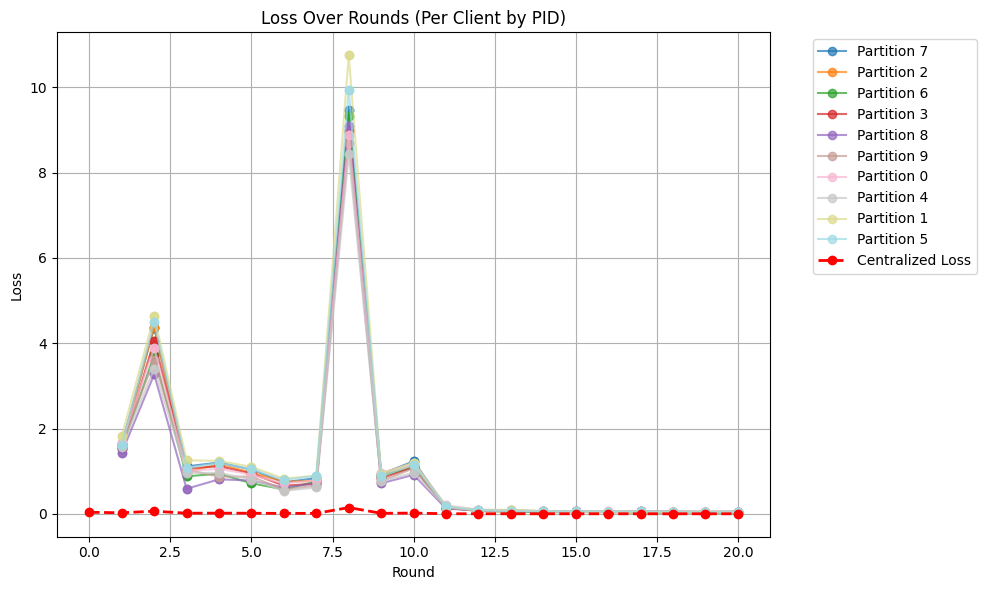

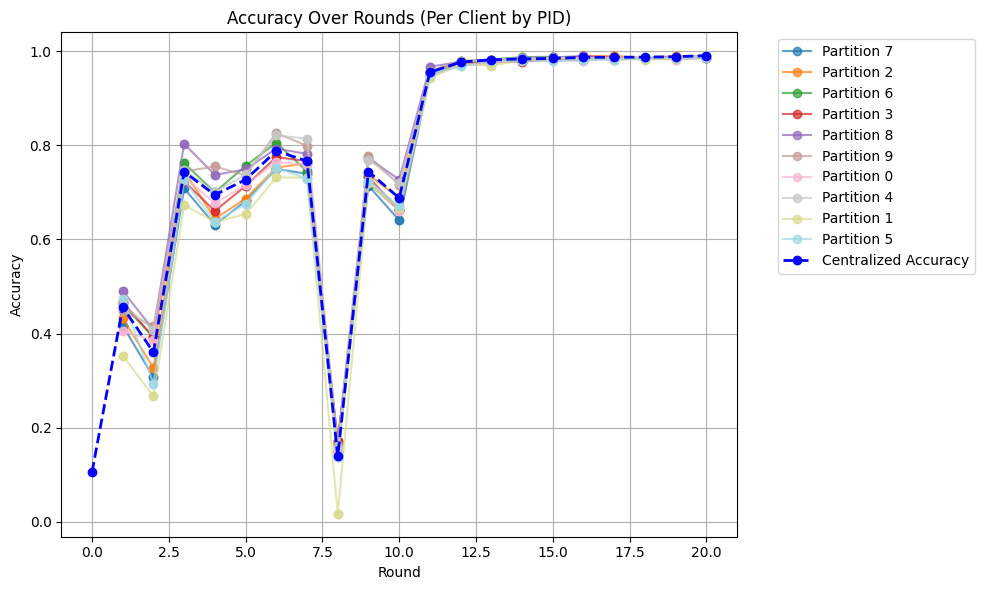

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ---------- 定義彩色配色方案和黑白友好的線條樣式 ----------
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # 彩色調色盤
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']  # 線條樣式
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h']  # 標記符號

# 提取每個 client（按 pid）的 loss 和 accuracy 數據
client_losses = {}  # {pid: [(round, loss), ...]}
client_accuracies = {}  # {pid: [(round, acc), ...]}

for round_num, pid, loss in history.losses_distributed:
    if pid not in client_losses:
        client_losses[pid] = []
    client_losses[pid].append((round_num, loss))

for round_num, pid, acc in history.metrics_distributed.get('accuracy', []):
    if pid not in client_accuracies:
        client_accuracies[pid] = []
    client_accuracies[pid].append((round_num, acc))

# 繪製每個 client 的 Loss 圖
plt.figure(figsize=(12, 7))

pid_list = list(client_losses.keys())
for i, pid in enumerate(pid_list):
    losses = client_losses[pid]
    rounds = [r for r, _ in sorted(losses)]
    loss_values = [l for _, l in sorted(losses)]
    
    plt.plot(rounds, loss_values, 
            marker=markers[i % len(markers)], 
            linestyle=line_styles[i % len(line_styles)],
            color=colors[i % len(colors)],      # 使用彩色
            linewidth=2.5,                      # 稍微加粗線條
            markersize=7,                       # 稍微放大標記
            markerfacecolor='white',            # 標記內部為白色
            markeredgewidth=2,                  # 標記邊框加粗
            markeredgecolor=colors[i % len(colors)],  # 標記邊框與線條同色
            label=f'Partition {pid}', 
            alpha=0.9)

# 繪製 centralized loss
rounds_loss = [t[0] for t in history.losses_centralized]
loss_values_centralized = [t[1] for t in history.losses_centralized]

plt.plot(rounds_loss, loss_values_centralized, 
        marker='*', 
        linestyle='-',
        color='red', 
        linewidth=3,
        markersize=10,
        markeredgewidth=2,
        markerfacecolor='white',
        markeredgecolor='red',
        label='Centralized Loss')

plt.xlabel('Round', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Over Rounds (Per Client by PID)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

# 繪製每個 client 的 Accuracy 圖
plt.figure(figsize=(12, 7))

pid_list = list(client_accuracies.keys())
for i, pid in enumerate(pid_list):
    accuracies = client_accuracies[pid]
    rounds = [r for r, _ in sorted(accuracies)]
    acc_values = [a for _, a in sorted(accuracies)]
    
    plt.plot(rounds, acc_values, 
            marker=markers[i % len(markers)], 
            linestyle=line_styles[i % len(line_styles)],
            color=colors[i % len(colors)],      # 使用彩色
            linewidth=2.5,                      # 稍微加粗線條
            markersize=7,                       # 稍微放大標記
            markerfacecolor='white',            # 標記內部為白色
            markeredgewidth=2,                  # 標記邊框加粗
            markeredgecolor=colors[i % len(colors)],  # 標記邊框與線條同色
            label=f'Partition {pid}', 
            alpha=0.9)

# 繪製 centralized accuracy
acc_rounds = [t[0] for t in history.metrics_centralized.get('accuracy', [])]
acc_values_centralized = [t[1] for t in history.metrics_centralized.get('accuracy', [])]

plt.plot(acc_rounds, acc_values_centralized, 
        marker='*', 
        linestyle='-',
        color='blue', 
        linewidth=3,
        markersize=10,
        markeredgewidth=2,
        markerfacecolor='white',
        markeredgecolor='blue',
        label='Centralized Accuracy')

plt.xlabel('Round', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Over Rounds (Per Client by PID)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

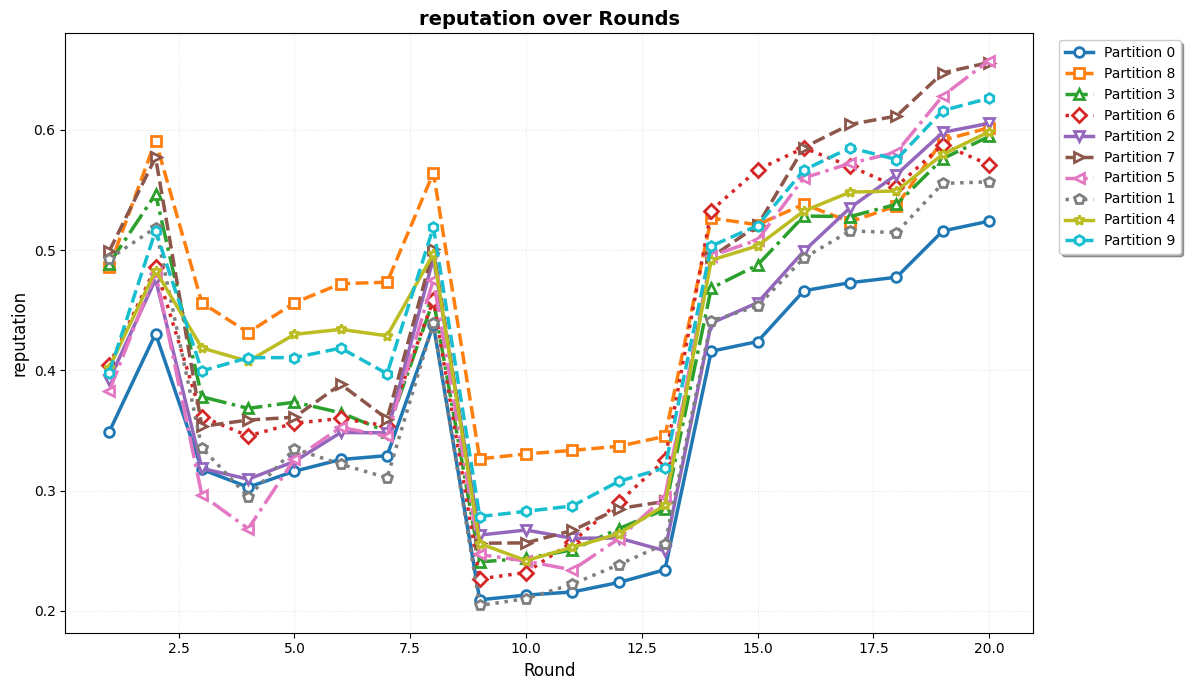

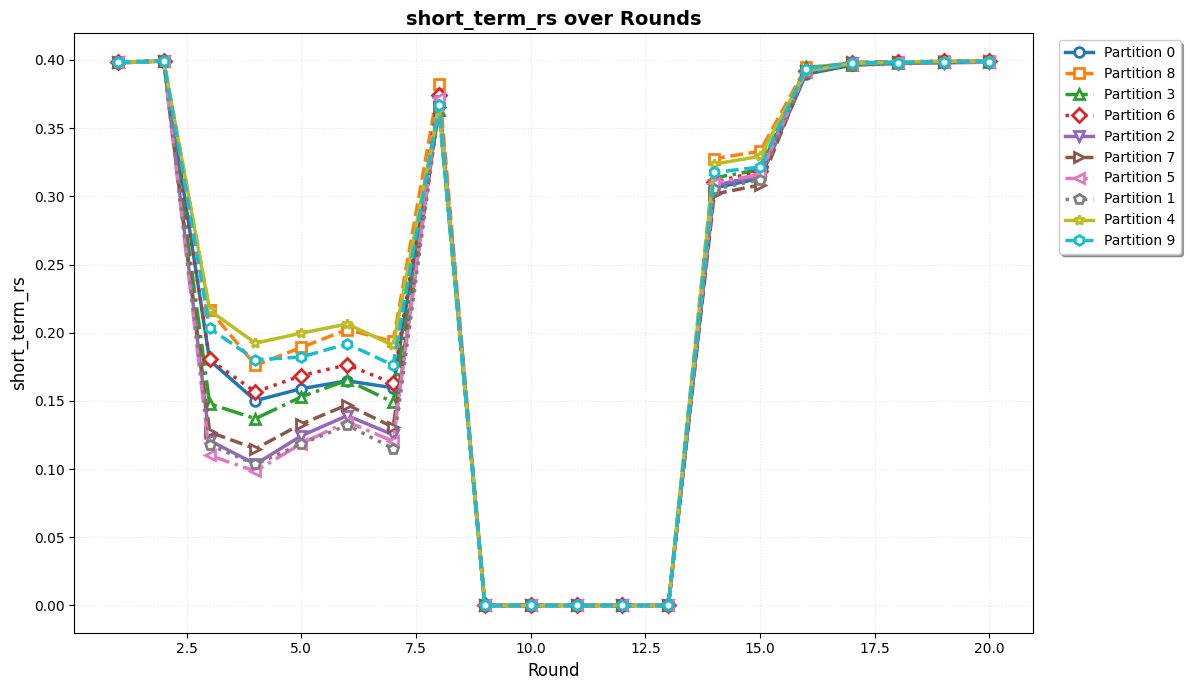

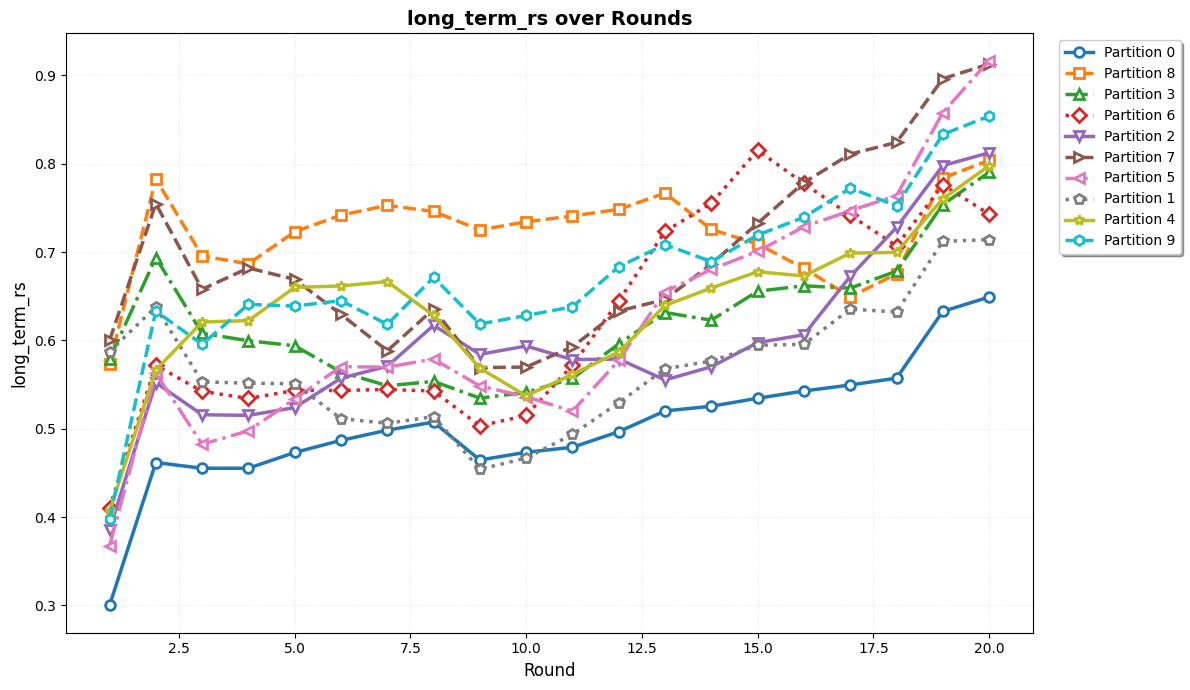

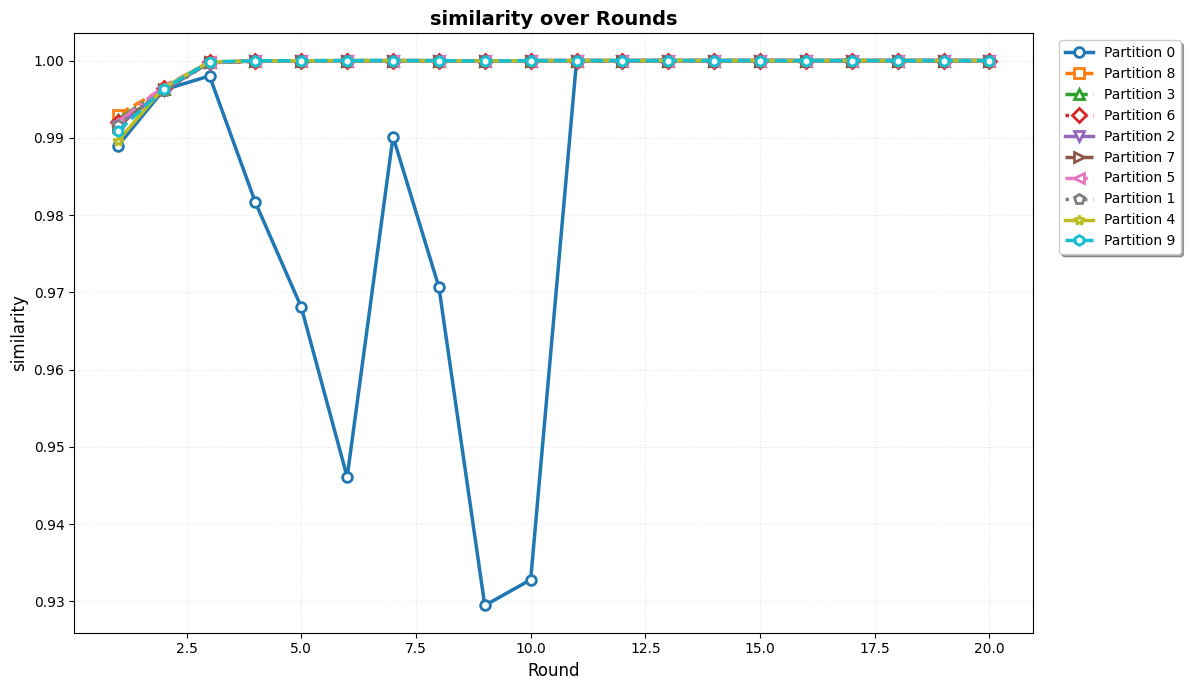

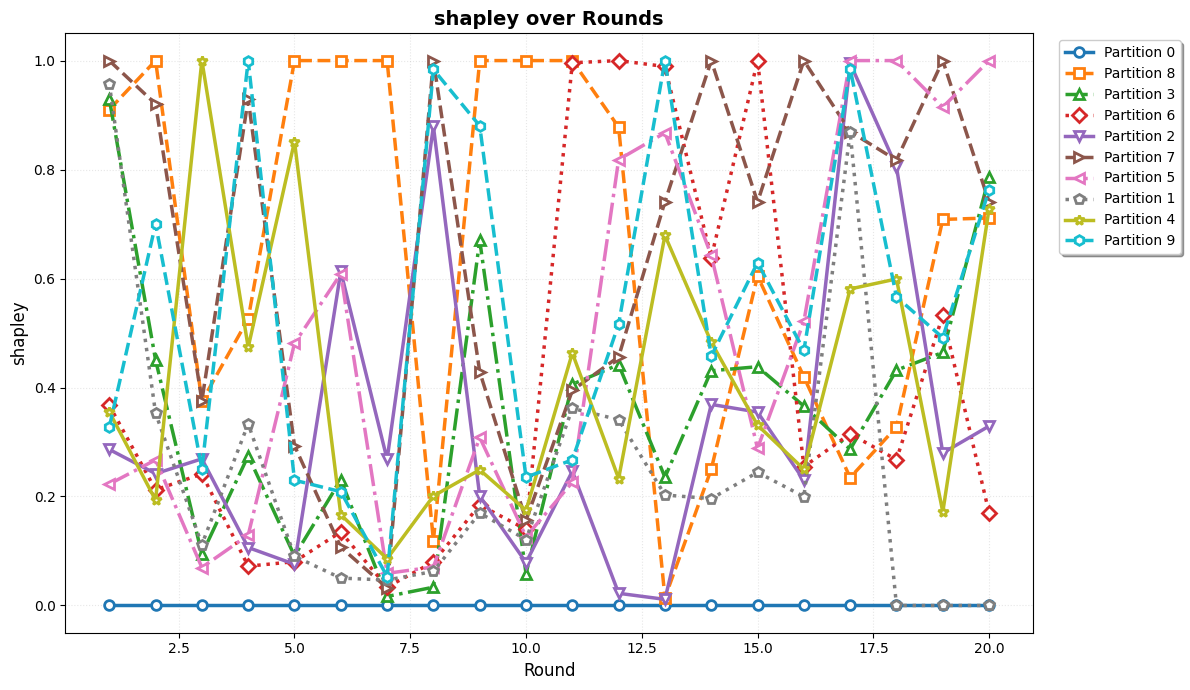

In [17]:
# ========= 訓練結束後繪圖 =========

# ---------- 定義彩色配色方案和黑白友好的線條樣式 ----------
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # 彩色調色盤
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']  # 線條樣式
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h']  # 標記符號

# 假設 NUM_ROUNDS 為全局訓練輪數
rounds = list(range(1, NUM_ROUNDS + 1))
metrics_to_plot = ['reputation', 'short_term_rs', 'long_term_rs', 'similarity', 'shapley']

# 從策略中提取 metric_history
metric_history = strategy.metric_history

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 7))
    
    partition_ids = list(metric_history.keys())
    for i, partition_id in enumerate(partition_ids):
        metrics_dict = metric_history[partition_id]
        values = metrics_dict[metric]
        
        # 若某 client 的紀錄少於 NUM_ROUNDS (代表部分 round 沒有更新)，則補上最後一次的值
        if len(values) < NUM_ROUNDS:
            last_val = values[-1] if values else 0.0
            values = values + [last_val] * (NUM_ROUNDS - len(values))
        
        plt.plot(rounds, values, 
                marker=markers[i % len(markers)], 
                linestyle=line_styles[i % len(line_styles)],
                color=colors[i % len(colors)],      # 使用彩色
                linewidth=2.5,                      # 稍微加粗線條
                markersize=7,                       # 稍微放大標記
                markerfacecolor='white',            # 標記內部為白色
                markeredgewidth=2,                  # 標記邊框加粗
                markeredgecolor=colors[i % len(colors)],  # 標記邊框與線條同色
                label=f'Partition {partition_id}')
    
    plt.xlabel('Round', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.title(f'{metric} over Rounds', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3, linestyle=':')
    plt.tight_layout()
    plt.show()


In [14]:
# history.metrics_centralized
best_epoch, best_accuracy = max(history.metrics_centralized['accuracy'], key=lambda x: x[1])

print(f"Best Epoch: {best_epoch}, Accuracy: {best_accuracy:.4f}")

Best Epoch: 20, Accuracy: 0.9906


In [15]:
import numpy as np

# 1. 從 history.losses_distributed 中整理出：{ round_num: [loss_client1, loss_client2, ...], ... }
accuracies_by_round = {}
for round_num, pid, loss in history.metrics_distributed.get('accuracy', []):
    if round_num not in accuracies_by_round:
        accuracies_by_round[round_num] = []
    accuracies_by_round[round_num].append(loss)

# 2. 按 round 排序，計算每一輪的 client_loss 標準差（母體標準差 ddof=0）
rounds = sorted(accuracies_by_round.keys())
fairness_std_per_round = []
for r in rounds:
    client_accuracies_this_round = accuracies_by_round[r]
    if len(client_accuracies_this_round) > 1:
        std_val = float(np.std(client_accuracies_this_round, ddof=0))
    else:
        std_val = 0.0  # 如果只有一個 client 或無資料，就設為 0
    fairness_std_per_round.append(std_val)


avg_fairness_std = float(np.mean(fairness_std_per_round))
# print("500 輪公平性標準差平均值：", avg_fairness_std)
# fairness_std_per_round

# 確定只考慮前500輪（若總輪次少於500，則全部都考慮）
num_rounds = min(500, len(fairness_std_per_round))
subset = fairness_std_per_round[:num_rounds]

# 取最小值
min_std = min(subset)

print(f"前 {num_rounds} 輪中，公平性標準差的最小值為：{min_std}")

前 20 輪中，公平性標準差的最小值為：0.001398270593897649


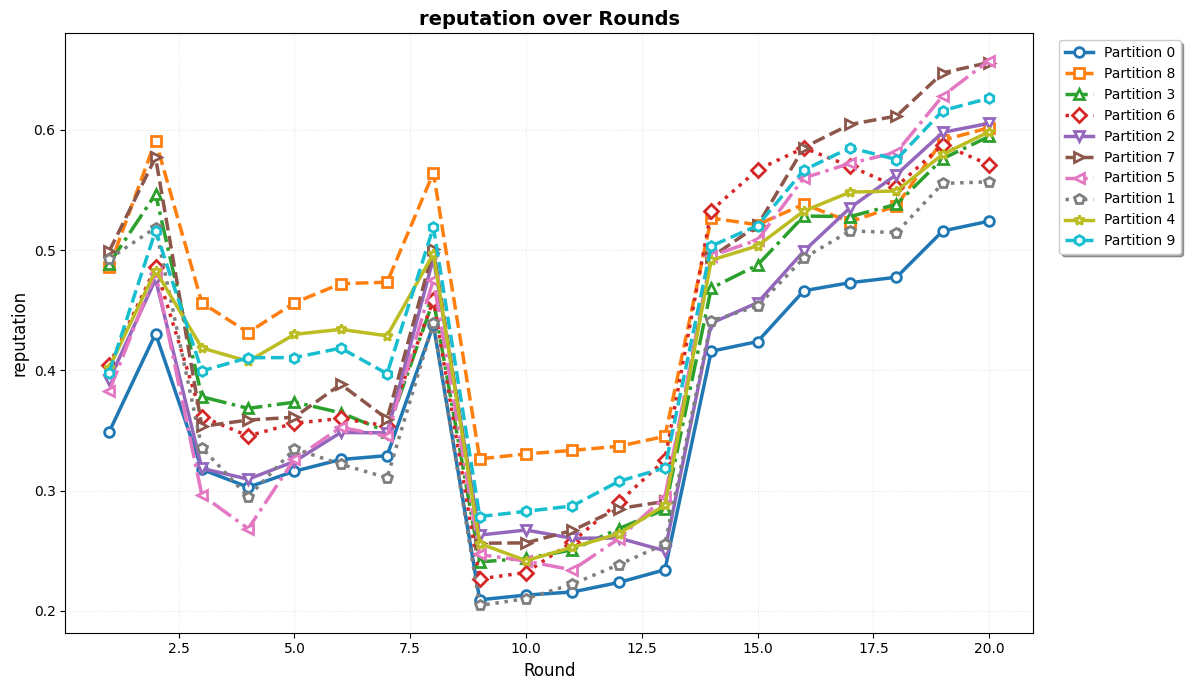

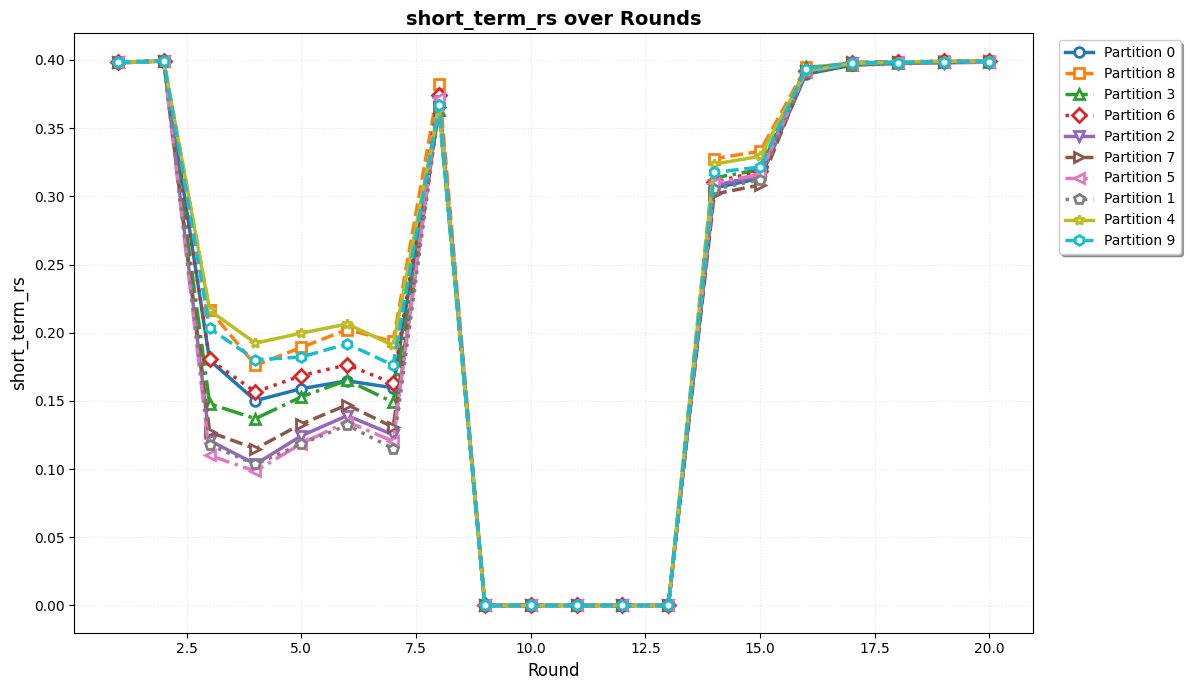

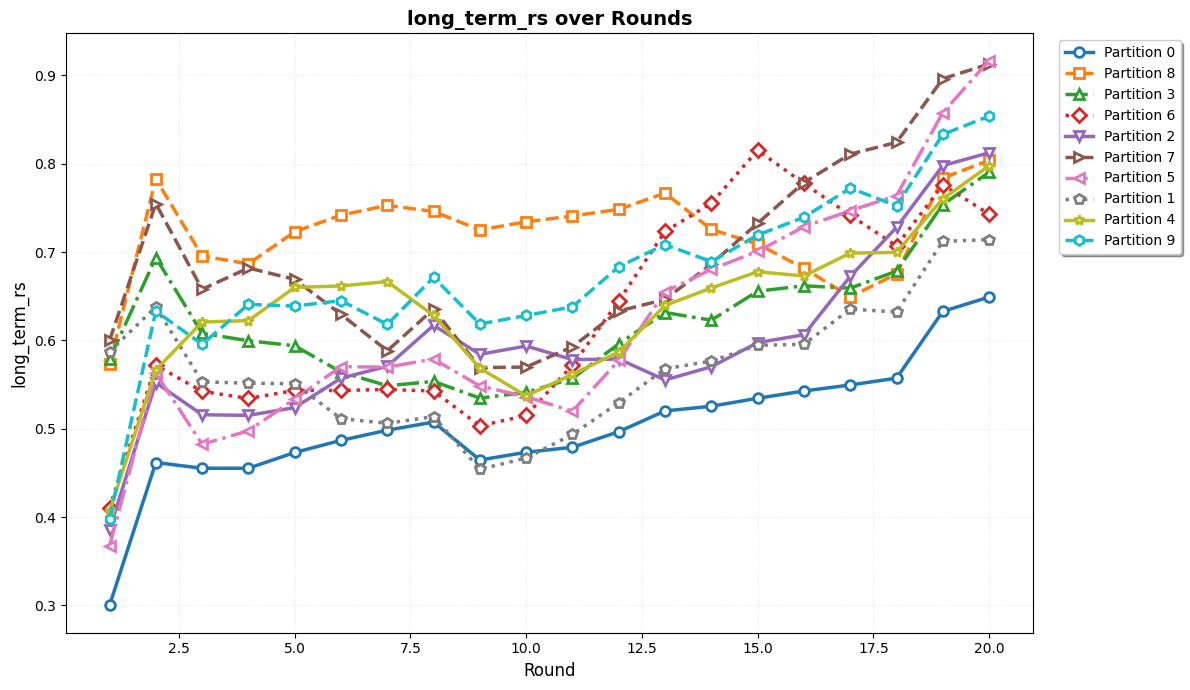

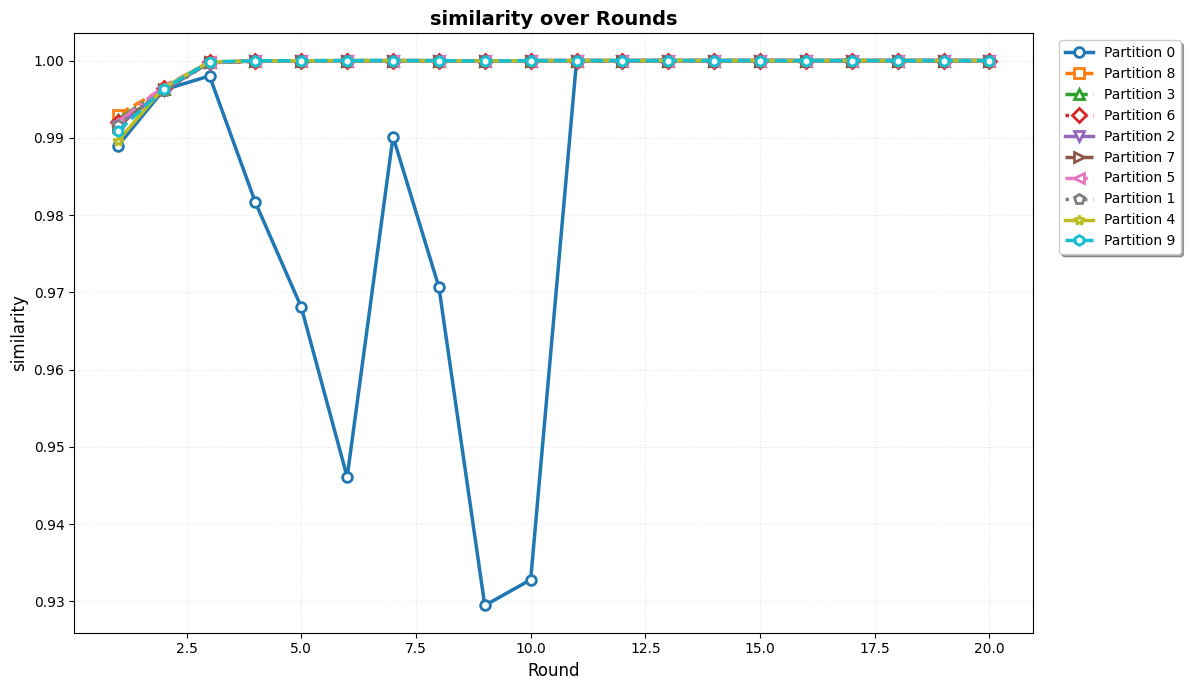

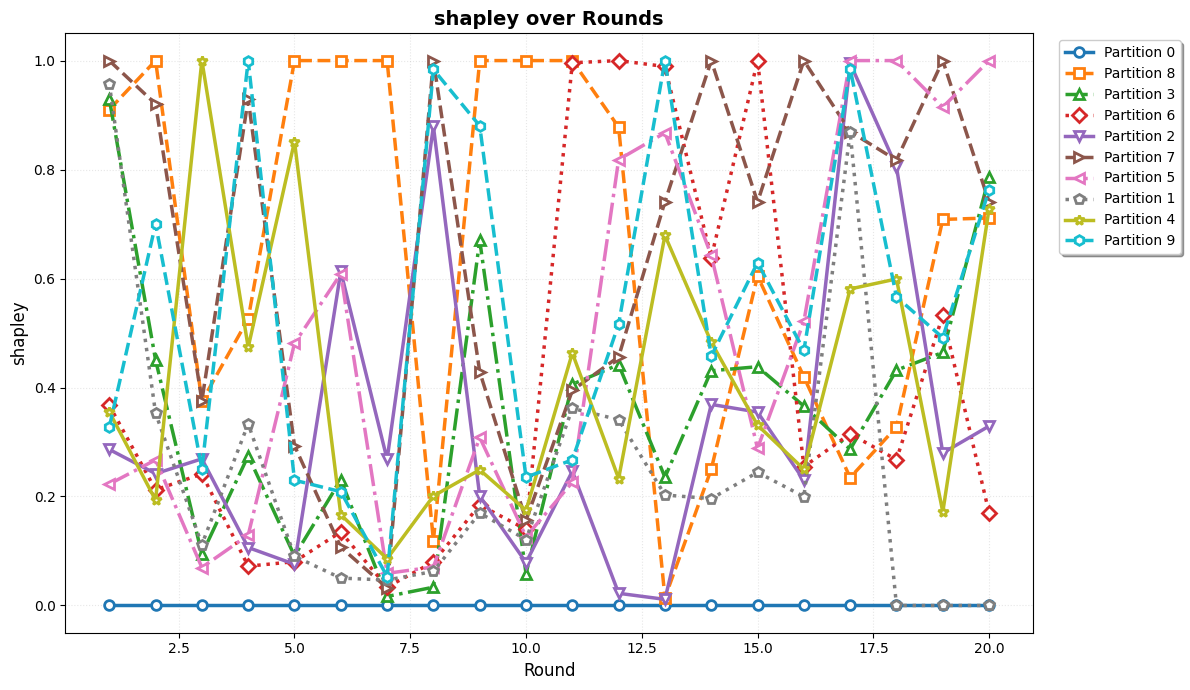

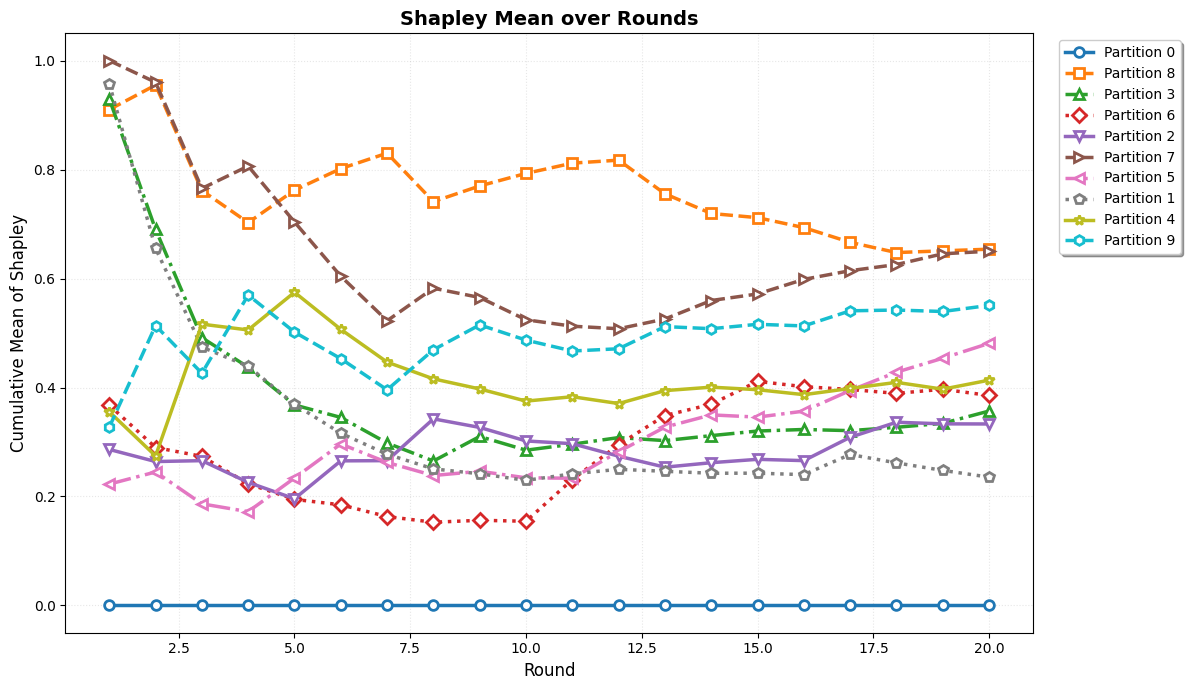

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 定義彩色配色方案和黑白友好的線條樣式 ----------
# 使用 matplotlib 的預設彩色調色盤，但加上不同線條樣式
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # 彩色調色盤
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']  # 線條樣式
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', '*', 'h']  # 標記符號

# ---------- 共同的 x-tick 刻度 ----------
tick_step = 2.5                              # 想要每 2.5 一格
xtick_vals = np.arange(tick_step, NUM_ROUNDS + tick_step, tick_step)

# ---------- 1. 五個原始指標 ----------
for metric in metrics_to_plot:
    plt.figure(figsize=(12, 7))
    
    partition_ids = list(metric_history.keys())
    for i, cid in enumerate(partition_ids):
        m = metric_history[cid]
        vals = m[metric]
        if len(vals) < NUM_ROUNDS:
            vals = vals + [vals[-1]] * (NUM_ROUNDS - len(vals))
        
        plt.plot(rounds, vals, 
                marker=markers[i % len(markers)], 
                linestyle=line_styles[i % len(line_styles)],
                color=colors[i % len(colors)],  # 使用彩色
                linewidth=2.5,                  # 稍微加粗線條
                markersize=7,                   # 稍微放大標記
                markerfacecolor='white',        # 標記內部為白色
                markeredgewidth=2,              # 標記邊框加粗
                markeredgecolor=colors[i % len(colors)],  # 標記邊框與線條同色
                label=f'Partition {cid}')
    
    plt.title(f'{metric} over Rounds', fontsize=14, fontweight='bold')
    plt.xlabel('Round', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.grid(True, alpha=0.3, linestyle=':')
    plt.xticks(xtick_vals)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, fancybox=True, shadow=True)
    plt.tight_layout()
    plt.show()

# ---------- 2. Shapley「歷史均值」 ----------
plt.figure(figsize=(12, 7))

partition_ids = list(metric_history.keys())
for i, cid in enumerate(partition_ids):
    m = metric_history[cid]
    vals = m['shapley']
    if len(vals) < NUM_ROUNDS:
        vals = vals + [vals[-1]] * (NUM_ROUNDS - len(vals))
    cum_mean = np.cumsum(vals) / np.arange(1, NUM_ROUNDS + 1)
    
    plt.plot(rounds, cum_mean, 
            marker=markers[i % len(markers)], 
            linestyle=line_styles[i % len(line_styles)],
            color=colors[i % len(colors)],      # 使用彩色
            linewidth=2.5,                      # 稍微加粗線條
            markersize=7,                       # 稍微放大標記
            markerfacecolor='white',            # 標記內部為白色
            markeredgewidth=2,                  # 標記邊框加粗
            markeredgecolor=colors[i % len(colors)],  # 標記邊框與線條同色
            label=f'Partition {cid}')

plt.title('Shapley Mean over Rounds', fontsize=14, fontweight='bold')
plt.xlabel('Round', fontsize=12)
plt.ylabel('Cumulative Mean of Shapley', fontsize=12)
plt.grid(True, alpha=0.3, linestyle=':')
plt.xticks(xtick_vals)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()
